# Basic imports and obtaining datasets

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path  # For defining dataset Paths
import sys                # For include librep package

# This must be done if librep is not installed via pip,
# as this directory (examples) is appart from librep package root
sys.path.append("..")

# Third party imports
import pandas as pd
import numpy as np

# Librep imports
from librep.utils.dataset import PandasDatasetsIO          # For quick load train, test and validation CSVs
from librep.datasets.multimodal import PandasMultiModalDataset # Wrap CSVs to librep's `Dataset` interface

2022-09-22 03:14:24.857555: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-22 03:14:24.857578: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
# Path for KuHar resampled to 20Hz view with the same activities (and labels numbers)
# It is assumed that the directory will contain (train.csv, test.csv and validation.csv)
dataset_path = Path("../data/views/KuHar/resampled_view_20Hz")

In [4]:
# Kuhar dataframes
train, validation, test = PandasDatasetsIO(dataset_path).load()

In [5]:
# Kuhar features to select
features = [
    "accel-x",
    "accel-y",
    "accel-z",
    "gyro-x",
    "gyro-y",
    "gyro-z"
]

# Creating the datasets

# Train
train_dataset = PandasMultiModalDataset(
    train,
    feature_prefixes=features,
    label_columns="activity code",
    as_array=True
)

# Validation
validation_dataset = PandasMultiModalDataset(
    validation,
    feature_prefixes=features,
    label_columns="activity code",
    as_array=True
)

# Test
test_dataset = PandasMultiModalDataset(
    test,
    feature_prefixes=features,
    label_columns="activity code",
    as_array=True
)

# Transforming KuHar to 20Hz

In [6]:
from librep.datasets.multimodal import TransformMultiModalDataset
from librep.transforms.fft import FFT

In [7]:
fft_transform = FFT(centered = True)
transformer = TransformMultiModalDataset(transforms=[fft_transform], new_window_name_prefix="fft.")

In [8]:
train_dataset_fft = transformer(train_dataset)
validation_dataset_fft = transformer(validation_dataset)
test_dataset_fft = transformer(test_dataset)

In [9]:
print(train_dataset_fft.X.shape)
print(validation_dataset_fft.X.shape)
print(test_dataset_fft.X.shape)

(3330, 180)
(108, 180)
(378, 180)


# Applying topological autoencoders

In [30]:
from librep.transforms.topo_ae import TopologicalDimensionalityReduction
from librep.metrics.dimred_evaluator import DimensionalityReductionQualityReport

dimensions = [1, 5, 7, 10, 15, 20, 50, 100]
topo_models = []
lowdim_test_dataset_fft = []
lowdim_train_dataset_fft = []
lowdim_pyDRMetrics_eval = []
lowdim_classification_eval = []

In [27]:
from librep.utils.workflow import SimpleTrainEvalWorkflow, MultiRunWorkflow
from librep.estimators import RandomForestClassifier
from librep.metrics.report import ClassificationReport
import yaml

reporter = ClassificationReport(use_accuracy=True, use_f1_score=True, use_classification_report=False, use_confusion_matrix=False, plot_confusion_matrix=False)
experiment = SimpleTrainEvalWorkflow(estimator=RandomForestClassifier, estimator_creation_kwags ={'n_estimators':100} , do_not_instantiate=False, do_fit=True, evaluator=reporter)
multi_run_experiment = MultiRunWorkflow(workflow=experiment, num_runs=3, debug=False)

def get_classification_metrics(train_x, train_y, test_x, test_y):
    train_x_pd = pd.DataFrame(train_x)
    train_x_pd['y'] = train_y
    train_dset = PandasMultiModalDataset(
        train_x_pd,
        label_columns="y",
        as_array=True
    )

    test_x_pd = pd.DataFrame(test_x)
    test_x_pd['y'] = test_y
    test_dset = PandasMultiModalDataset(
        test_x_pd,
        label_columns="y",
        as_array=True
    )

    result = multi_run_experiment(train_dset, test_dset)
    return result
# result = multi_run_experiment(combined_train_dset, test_dataset)
# print(yaml.dump(result, sort_keys=True, indent=4))

In [28]:
print(test_dataset_fft.X.shape, test_dataset_fft.X.shape)

(378, 180) (378, 180)


In [13]:
# print(test_dataset_after_topoae_transform.shape)

In [14]:
# print(train_dataset_after_topoae_transform.shape)

START DIMENSION 1
Topologically Regularized DeepAEforKuhar180ver2
Using python to compute signatures
DeepAEforKuhar180ver2, Input: 180 Inner dim: 1
Epoch:1, Loss:380.8250, Loss-ae:370.5149, Loss-topo:10.3100
Epoch:2, Loss:336.7489, Loss-ae:302.5087, Loss-topo:34.2402
Epoch:3, Loss:276.1472, Loss-ae:273.4547, Loss-topo:2.6925
Epoch:4, Loss:260.6417, Loss-ae:258.9068, Loss-topo:1.7348
Epoch:5, Loss:272.5947, Loss-ae:270.6705, Loss-topo:1.9242
Epoch:6, Loss:268.4410, Loss-ae:262.6953, Loss-topo:5.7456
Epoch:7, Loss:244.3832, Loss-ae:243.1606, Loss-topo:1.2226
Epoch:8, Loss:237.9285, Loss-ae:236.4521, Loss-topo:1.4764
Epoch:9, Loss:226.0994, Loss-ae:225.4814, Loss-topo:0.6180
Epoch:10, Loss:224.7593, Loss-ae:224.1144, Loss-topo:0.6448
Epoch:11, Loss:231.4564, Loss-ae:230.7980, Loss-topo:0.6584
Epoch:12, Loss:214.9335, Loss-ae:214.0334, Loss-topo:0.9002
Epoch:13, Loss:237.6407, Loss-ae:236.3764, Loss-topo:1.2644
Epoch:14, Loss:207.8274, Loss-ae:207.2375, Loss-topo:0.5899
Epoch:15, Loss:272.

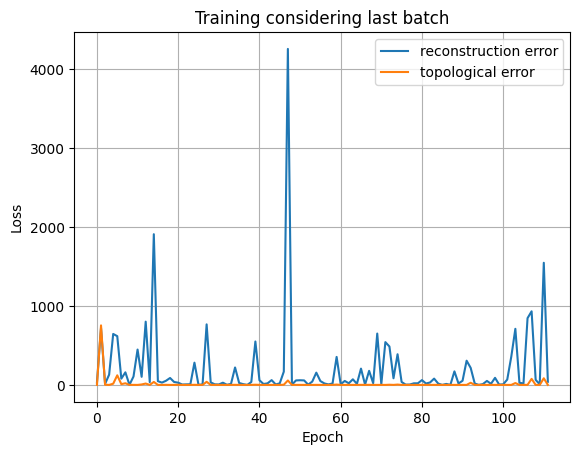

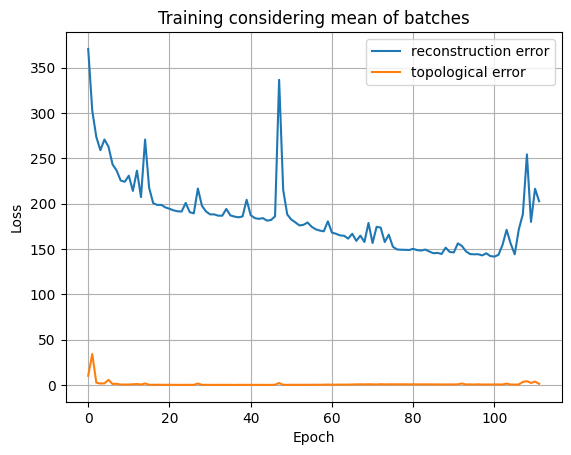

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


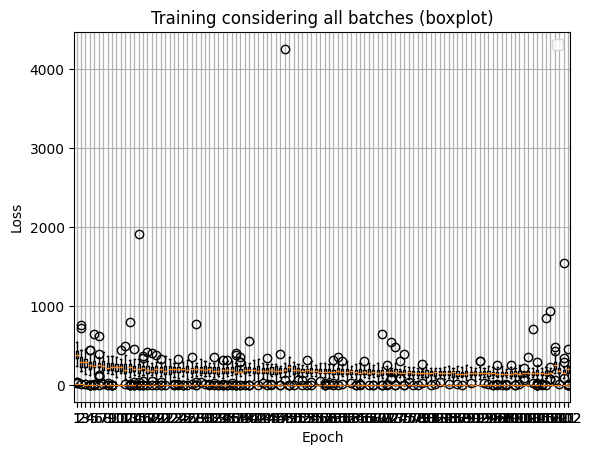

START DIMENSION 5
Topologically Regularized DeepAEforKuhar180ver2
Using python to compute signatures
DeepAEforKuhar180ver2, Input: 180 Inner dim: 5
Epoch:1, Loss:480.1070, Loss-ae:417.7218, Loss-topo:62.3851
Epoch:2, Loss:310.8542, Loss-ae:308.5586, Loss-topo:2.2957
Epoch:3, Loss:319.7112, Loss-ae:310.4786, Loss-topo:9.2326
Epoch:4, Loss:290.6641, Loss-ae:288.7562, Loss-topo:1.9079
Epoch:5, Loss:284.8165, Loss-ae:283.0296, Loss-topo:1.7869
Epoch:6, Loss:301.5728, Loss-ae:299.2765, Loss-topo:2.2963
Epoch:7, Loss:254.9396, Loss-ae:253.7693, Loss-topo:1.1703
Epoch:8, Loss:240.8544, Loss-ae:239.2614, Loss-topo:1.5930
Epoch:9, Loss:229.3265, Loss-ae:221.1950, Loss-topo:8.1315
Epoch:10, Loss:205.4532, Loss-ae:203.6803, Loss-topo:1.7728
Epoch:11, Loss:198.1483, Loss-ae:196.4357, Loss-topo:1.7126
Epoch:12, Loss:192.2875, Loss-ae:190.0926, Loss-topo:2.1949
Epoch:13, Loss:184.3506, Loss-ae:182.4485, Loss-topo:1.9021
Epoch:14, Loss:175.1506, Loss-ae:172.9561, Loss-topo:2.1945
Epoch:15, Loss:165.5

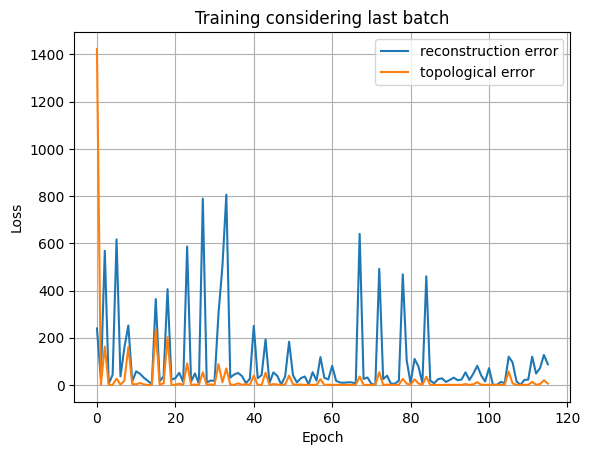

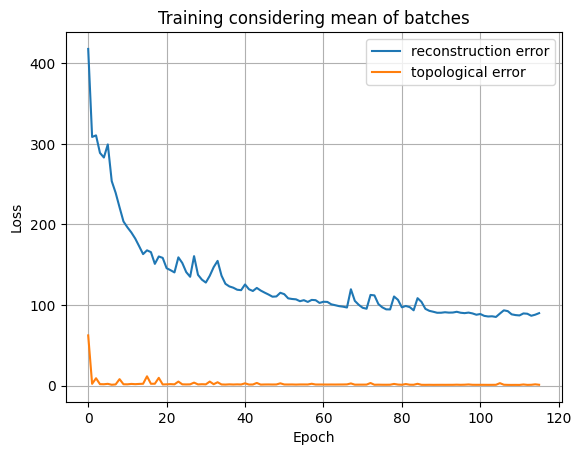

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


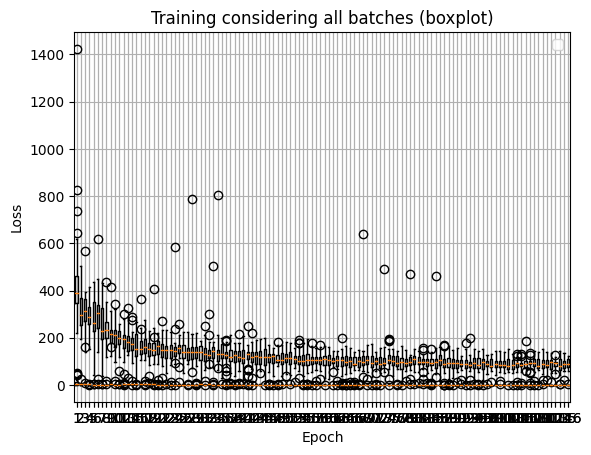

START DIMENSION 7
Topologically Regularized DeepAEforKuhar180ver2
Using python to compute signatures
DeepAEforKuhar180ver2, Input: 180 Inner dim: 7
Epoch:1, Loss:617.9662, Loss-ae:467.3383, Loss-topo:150.6279
Epoch:2, Loss:329.8649, Loss-ae:322.1657, Loss-topo:7.6992
Epoch:3, Loss:301.1484, Loss-ae:298.4244, Loss-topo:2.7240
Epoch:4, Loss:288.5130, Loss-ae:285.5539, Loss-topo:2.9590
Epoch:5, Loss:274.0296, Loss-ae:271.8856, Loss-topo:2.1441
Epoch:6, Loss:256.1852, Loss-ae:254.5368, Loss-topo:1.6484
Epoch:7, Loss:239.4221, Loss-ae:237.5941, Loss-topo:1.8280
Epoch:8, Loss:234.9601, Loss-ae:227.7822, Loss-topo:7.1779
Epoch:9, Loss:205.6229, Loss-ae:203.2281, Loss-topo:2.3947
Epoch:10, Loss:254.4049, Loss-ae:245.6304, Loss-topo:8.7744
Epoch:11, Loss:206.8583, Loss-ae:205.3550, Loss-topo:1.5033
Epoch:12, Loss:192.5465, Loss-ae:190.9115, Loss-topo:1.6351
Epoch:13, Loss:185.6359, Loss-ae:184.0000, Loss-topo:1.6360
Epoch:14, Loss:180.5622, Loss-ae:178.5973, Loss-topo:1.9649
Epoch:15, Loss:168.

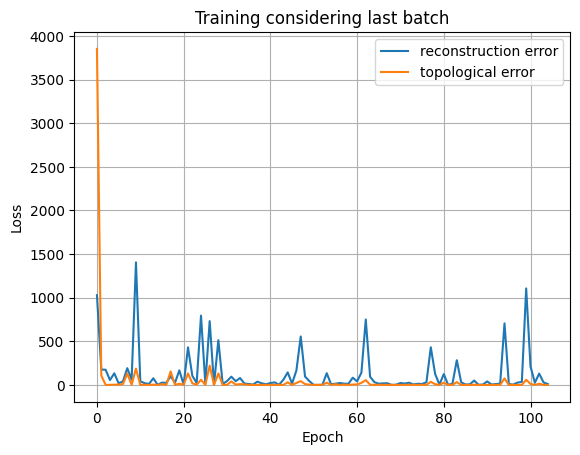

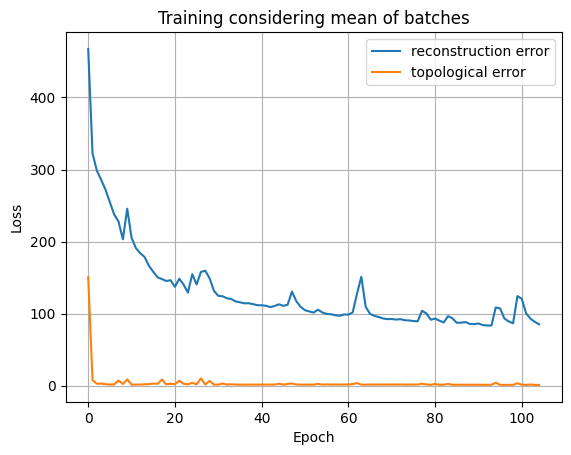

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


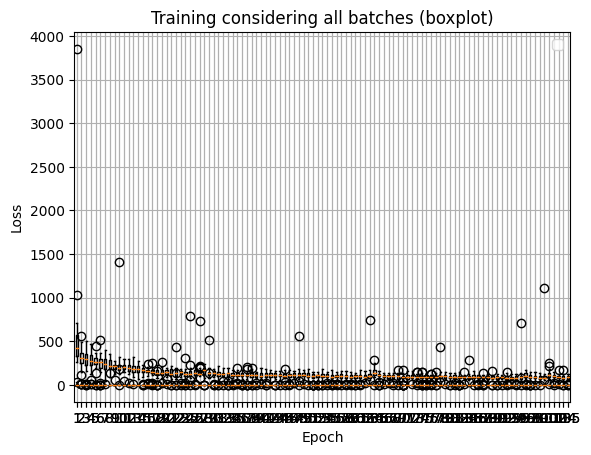

START DIMENSION 10
Topologically Regularized DeepAEforKuhar180ver2
Using python to compute signatures
DeepAEforKuhar180ver2, Input: 180 Inner dim: 10
Epoch:1, Loss:402.2716, Loss-ae:391.7779, Loss-topo:10.4937
Epoch:2, Loss:275.9225, Loss-ae:268.2890, Loss-topo:7.6335
Epoch:3, Loss:349.2349, Loss-ae:295.9954, Loss-topo:53.2395
Epoch:4, Loss:279.8394, Loss-ae:278.7087, Loss-topo:1.1307
Epoch:5, Loss:330.1226, Loss-ae:317.4354, Loss-topo:12.6872
Epoch:6, Loss:254.5831, Loss-ae:253.5485, Loss-topo:1.0347
Epoch:7, Loss:271.3998, Loss-ae:270.4567, Loss-topo:0.9431
Epoch:8, Loss:239.4588, Loss-ae:238.8620, Loss-topo:0.5968
Epoch:9, Loss:237.0850, Loss-ae:236.4629, Loss-topo:0.6220
Epoch:10, Loss:233.5547, Loss-ae:232.5815, Loss-topo:0.9732
Epoch:11, Loss:212.9562, Loss-ae:211.2886, Loss-topo:1.6676
Epoch:12, Loss:258.8378, Loss-ae:248.3704, Loss-topo:10.4674
Epoch:13, Loss:210.3655, Loss-ae:208.6343, Loss-topo:1.7312
Epoch:14, Loss:190.9626, Loss-ae:188.2085, Loss-topo:2.7541
Epoch:15, Loss:

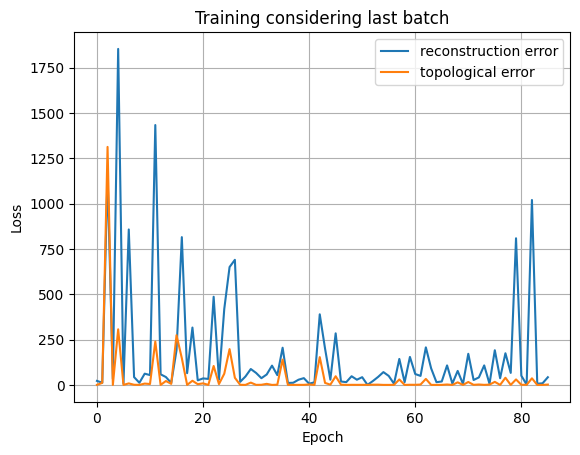

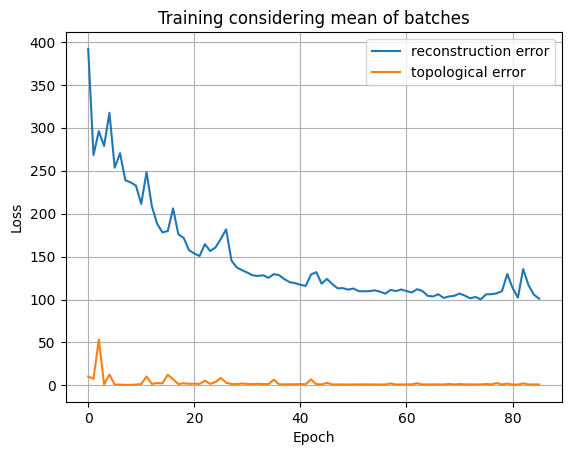

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


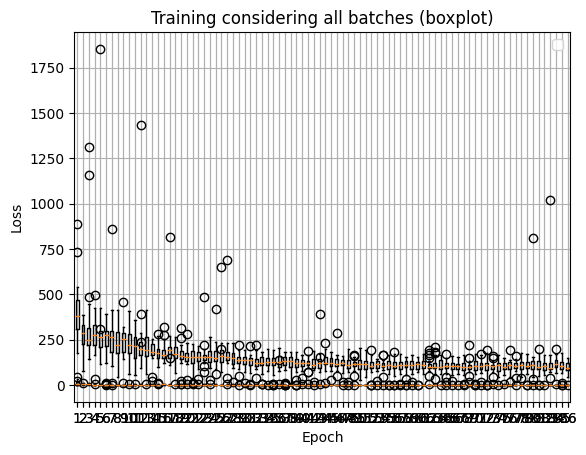

START DIMENSION 15
Topologically Regularized DeepAEforKuhar180ver2
Using python to compute signatures
DeepAEforKuhar180ver2, Input: 180 Inner dim: 15
Epoch:1, Loss:437.2591, Loss-ae:428.2681, Loss-topo:8.9910
Epoch:2, Loss:335.3933, Loss-ae:319.9260, Loss-topo:15.4673
Epoch:3, Loss:306.1231, Loss-ae:299.5186, Loss-topo:6.6046
Epoch:4, Loss:281.5969, Loss-ae:278.9116, Loss-topo:2.6853
Epoch:5, Loss:268.6141, Loss-ae:266.7689, Loss-topo:1.8452
Epoch:6, Loss:302.1918, Loss-ae:291.3107, Loss-topo:10.8811
Epoch:7, Loss:255.6792, Loss-ae:254.6315, Loss-topo:1.0477
Epoch:8, Loss:241.4729, Loss-ae:240.6239, Loss-topo:0.8490
Epoch:9, Loss:241.0108, Loss-ae:240.1894, Loss-topo:0.8214
Epoch:10, Loss:236.1245, Loss-ae:235.3445, Loss-topo:0.7800
Epoch:11, Loss:233.1915, Loss-ae:228.8105, Loss-topo:4.3810
Epoch:12, Loss:205.7882, Loss-ae:203.8739, Loss-topo:1.9143
Epoch:13, Loss:194.5127, Loss-ae:192.7792, Loss-topo:1.7335
Epoch:14, Loss:189.0009, Loss-ae:186.3661, Loss-topo:2.6348
Epoch:15, Loss:17

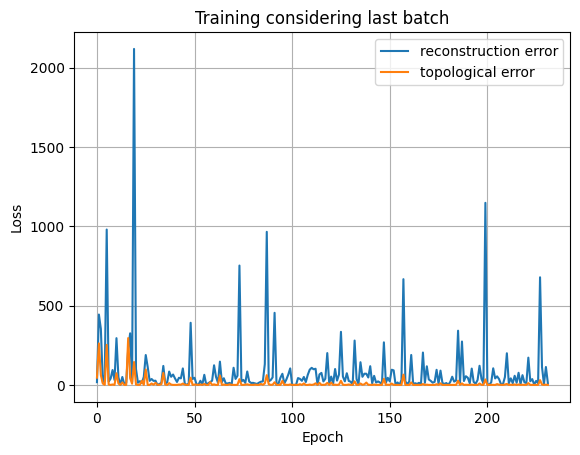

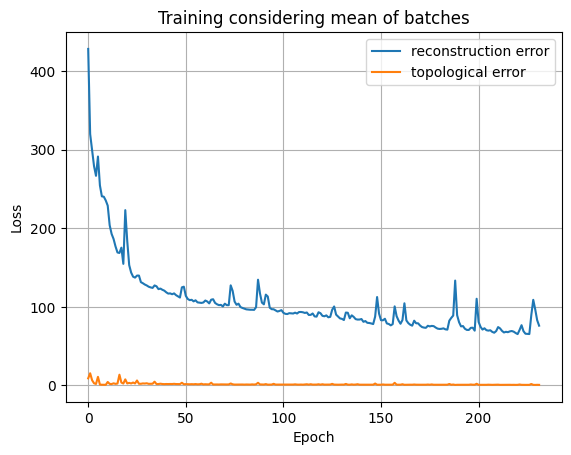

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


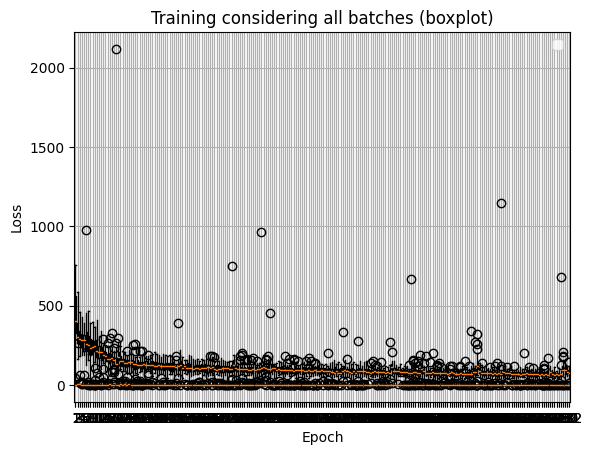

START DIMENSION 20
Topologically Regularized DeepAEforKuhar180ver2
Using python to compute signatures
DeepAEforKuhar180ver2, Input: 180 Inner dim: 20
Epoch:1, Loss:452.6315, Loss-ae:439.2751, Loss-topo:13.3564
Epoch:2, Loss:309.0446, Loss-ae:302.3730, Loss-topo:6.6717
Epoch:3, Loss:279.6398, Loss-ae:275.5449, Loss-topo:4.0948
Epoch:4, Loss:270.3207, Loss-ae:267.0553, Loss-topo:3.2653
Epoch:5, Loss:258.0165, Loss-ae:255.7152, Loss-topo:2.3012
Epoch:6, Loss:246.0212, Loss-ae:244.4493, Loss-topo:1.5718
Epoch:7, Loss:242.8925, Loss-ae:241.6169, Loss-topo:1.2756
Epoch:8, Loss:319.4099, Loss-ae:293.2603, Loss-topo:26.1496
Epoch:9, Loss:233.8988, Loss-ae:232.1831, Loss-topo:1.7157
Epoch:10, Loss:203.7510, Loss-ae:201.7290, Loss-topo:2.0220
Epoch:11, Loss:195.4032, Loss-ae:193.0302, Loss-topo:2.3730
Epoch:12, Loss:189.0404, Loss-ae:186.5449, Loss-topo:2.4955
Epoch:13, Loss:206.8563, Loss-ae:197.2522, Loss-topo:9.6041
Epoch:14, Loss:198.1508, Loss-ae:195.1157, Loss-topo:3.0350
Epoch:15, Loss:17

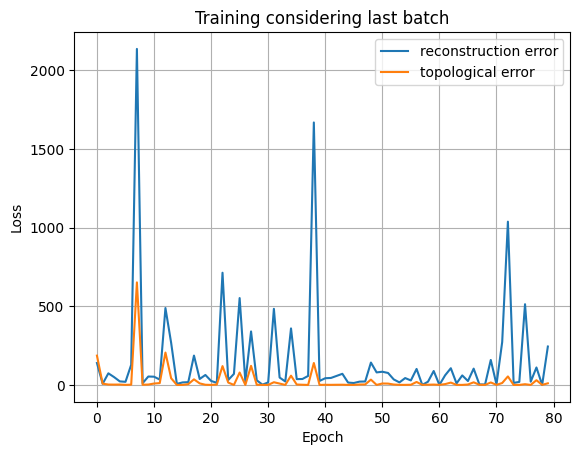

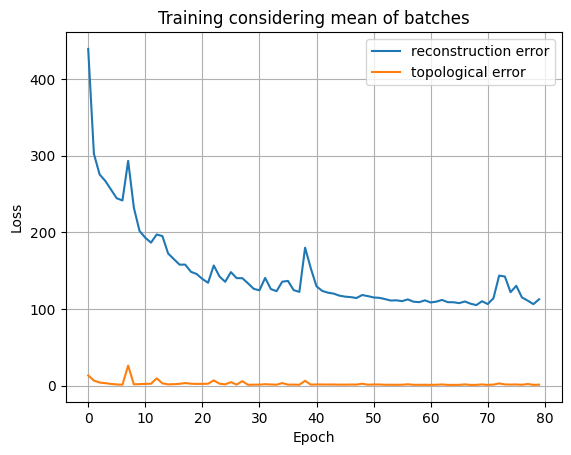

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


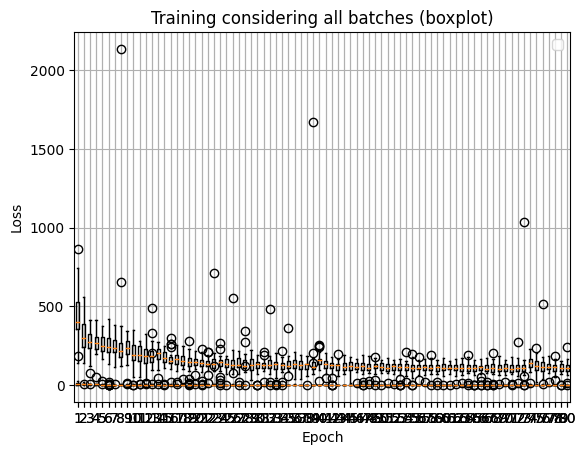

START DIMENSION 50
Topologically Regularized DeepAEforKuhar180ver2
Using python to compute signatures
DeepAEforKuhar180ver2, Input: 180 Inner dim: 50
Epoch:1, Loss:458.9193, Loss-ae:455.6770, Loss-topo:3.2422
Epoch:2, Loss:293.3403, Loss-ae:286.8299, Loss-topo:6.5104
Epoch:3, Loss:272.2071, Loss-ae:268.2550, Loss-topo:3.9522
Epoch:4, Loss:302.1507, Loss-ae:291.3201, Loss-topo:10.8306
Epoch:5, Loss:267.8759, Loss-ae:267.1073, Loss-topo:0.7686
Epoch:6, Loss:256.0878, Loss-ae:255.3760, Loss-topo:0.7118
Epoch:7, Loss:241.3585, Loss-ae:240.7684, Loss-topo:0.5901
Epoch:8, Loss:242.8644, Loss-ae:242.0848, Loss-topo:0.7796
Epoch:9, Loss:231.5936, Loss-ae:230.7247, Loss-topo:0.8689
Epoch:10, Loss:209.7370, Loss-ae:207.8154, Loss-topo:1.9216
Epoch:11, Loss:198.3911, Loss-ae:196.7373, Loss-topo:1.6539
Epoch:12, Loss:191.0644, Loss-ae:189.2610, Loss-topo:1.8034
Epoch:13, Loss:190.2918, Loss-ae:185.9434, Loss-topo:4.3484
Epoch:14, Loss:200.5347, Loss-ae:197.5657, Loss-topo:2.9690
Epoch:15, Loss:193

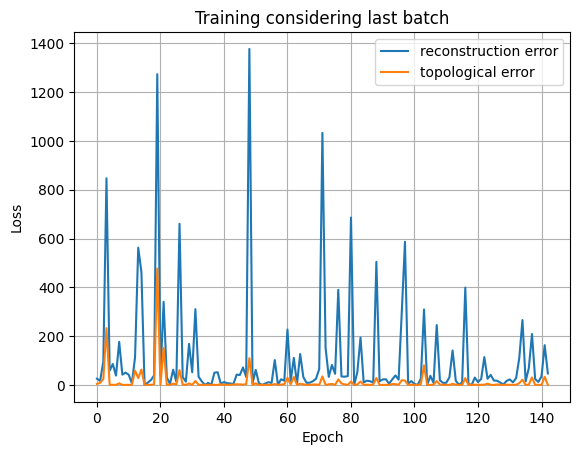

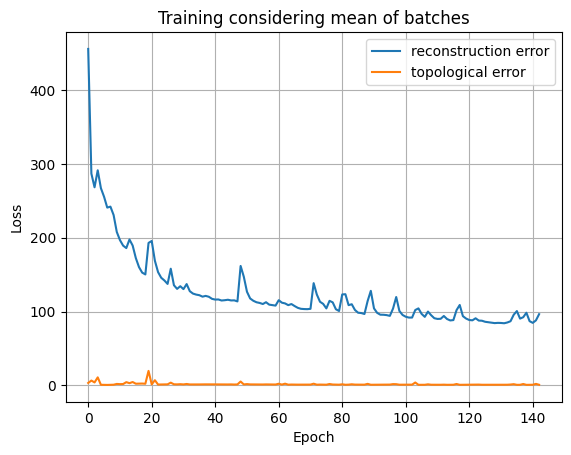

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


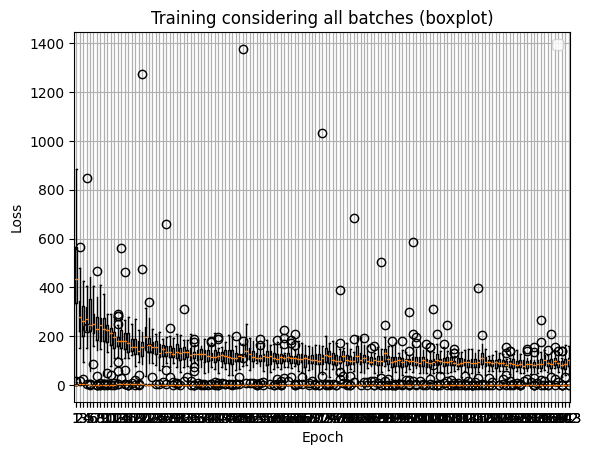

START DIMENSION 100
Topologically Regularized DeepAEforKuhar180ver2
Using python to compute signatures
DeepAEforKuhar180ver2, Input: 180 Inner dim: 100
Epoch:1, Loss:528.6186, Loss-ae:512.9773, Loss-topo:15.6413
Epoch:2, Loss:337.6590, Loss-ae:330.7221, Loss-topo:6.9369
Epoch:3, Loss:290.5553, Loss-ae:286.0078, Loss-topo:4.5474
Epoch:4, Loss:278.3913, Loss-ae:275.7556, Loss-topo:2.6357
Epoch:5, Loss:270.2273, Loss-ae:268.4358, Loss-topo:1.7915
Epoch:6, Loss:263.7243, Loss-ae:262.0938, Loss-topo:1.6305
Epoch:7, Loss:240.7875, Loss-ae:239.8081, Loss-topo:0.9794
Epoch:8, Loss:238.8513, Loss-ae:237.7001, Loss-topo:1.1512
Epoch:9, Loss:237.1066, Loss-ae:236.3961, Loss-topo:0.7105
Epoch:10, Loss:237.6876, Loss-ae:236.9677, Loss-topo:0.7199
Epoch:11, Loss:218.1286, Loss-ae:216.3723, Loss-topo:1.7562
Epoch:12, Loss:212.5656, Loss-ae:207.1734, Loss-topo:5.3922
Epoch:13, Loss:197.9215, Loss-ae:196.4320, Loss-topo:1.4895
Epoch:14, Loss:190.4156, Loss-ae:188.8109, Loss-topo:1.6047
Epoch:15, Loss:1

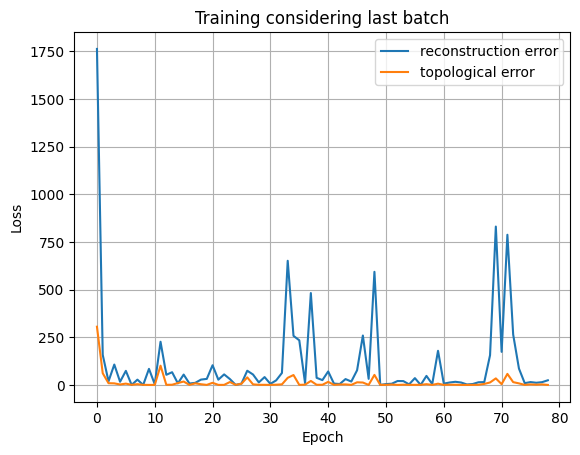

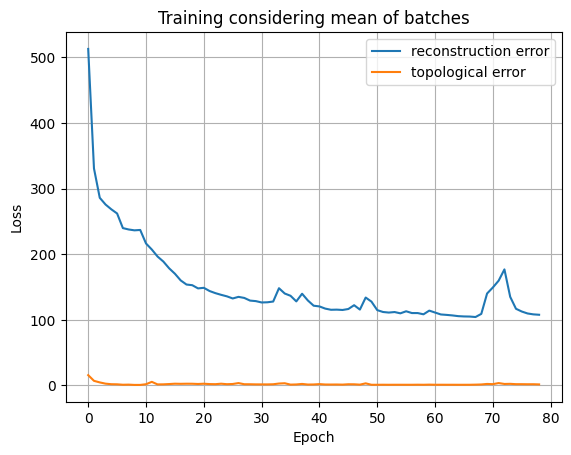

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


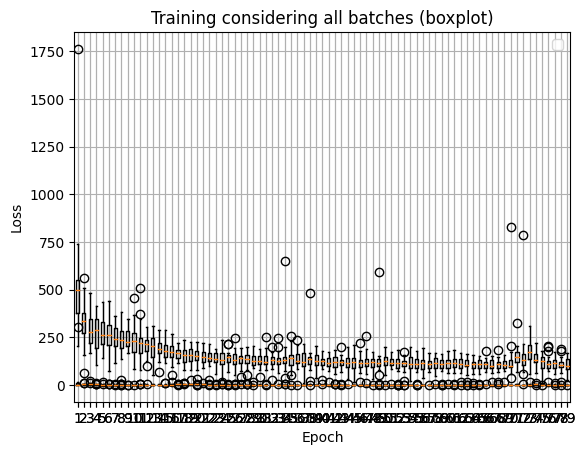

In [31]:
for i in dimensions:
    print('START DIMENSION', i)
    transformer_topoae = TopologicalDimensionalityReduction(ae_model='DeepAEforKuhar180ver2',
                                                          ae_kwargs={'input_dims':180, 'custom_dim':i},
                                                          input_shape=(-1, 1, 180))
    transformer_topoae.fit(train_dataset_fft.X)
    topo_models.append(transformer_topoae)
    
    # Applying topological autoencoders to train dataset
    train_dataset_after_topoae_transform = transformer_topoae.transform(train_dataset_fft.X)
    train_dataset_after_topoae_transform = np.reshape(train_dataset_after_topoae_transform, (-1,i))
    lowdim_train_dataset_fft.append(train_dataset_after_topoae_transform)
    
    # Applying topological autoencoders to test dataset
    test_dataset_after_topoae_transform = transformer_topoae.transform(test_dataset_fft.X)
    # print(test_dataset_after_topoae_transform.shape)
    test_dataset_after_topoae_transform = np.reshape(test_dataset_after_topoae_transform, (-1,i))
    lowdim_test_dataset_fft.append(test_dataset_after_topoae_transform)
    
    # Evaluating pyDRMetrics to test dataset
    metrics_reporter = DimensionalityReductionQualityReport(sampling_threshold=378)
    metrics_on_test_dataset = metrics_reporter.evaluate([test_dataset_fft.X, test_dataset_after_topoae_transform])
    
    lowdim_pyDRMetrics_eval.append(metrics_on_test_dataset)
    
    # Evaluating classification metrics to test dataset
    lowdim_classification_eval.append(get_classification_metrics(train_dataset_after_topoae_transform,
                                                                 train_dataset_fft.y, 
                                                                 test_dataset_after_topoae_transform,
                                                                 test_dataset_fft.y)) 

In [32]:
criteria = 'trustworthiness'
values = [evaluation[criteria] for evaluation in lowdim_pyDRMetrics_eval]
print(values)

[0.8295315106137534, 0.9402567653952696, 0.9344883612423492, 0.9308898249042962, 0.9476205390273114, 0.9198274025143831, 0.9290441743756291, 0.9239572694475264]


In [33]:
print(lowdim_pyDRMetrics_eval)

[{'residual variance (pearson)': 0.2032006816432972, 'residual variance (spearman)': 0.3584920768624009, 'trustworthiness': 0.8295315106137534, 'continuity': 0.9289266111670352, 'co k nearest neighbor size': 0.2801724137931034, 'local continuity meta criterion': 0.23761922230374172, 'local property': 0.43693417216282576, 'global property': 0.8507533297023575}, {'residual variance (pearson)': 0.07580805613755626, 'residual variance (spearman)': 0.09807744803431817, 'trustworthiness': 0.9402567653952696, 'continuity': 0.9752961123316458, 'co k nearest neighbor size': 0.5349801061007957, 'local continuity meta criterion': 0.492426914611434, 'local property': 0.571315466593259, 'global property': 0.8872665747769213}, {'residual variance (pearson)': 0.1427862981526582, 'residual variance (spearman)': 0.12253791380629098, 'trustworthiness': 0.9344883612423492, 'continuity': 0.9690239314606494, 'co k nearest neighbor size': 0.4971816976127321, 'local continuity meta criterion': 0.454628506123

In [34]:
import matplotlib.pyplot as plt

def plot_criteria(criteria):
    values = [evaluation[criteria] for evaluation in lowdim_pyDRMetrics_eval]
    x = np.array(range(len(dimensions)))
    my_xticks = [str(val) for val in dimensions]
    plt.xticks(x, my_xticks)
    plt.grid()
    plt.plot(values)
    plt.title(criteria + ' over dimensionalities')
    plt.ylabel(criteria + ' - metric value')
    plt.xlabel('dimensionality')
    plt.ylim((0,1))
    plt.show()

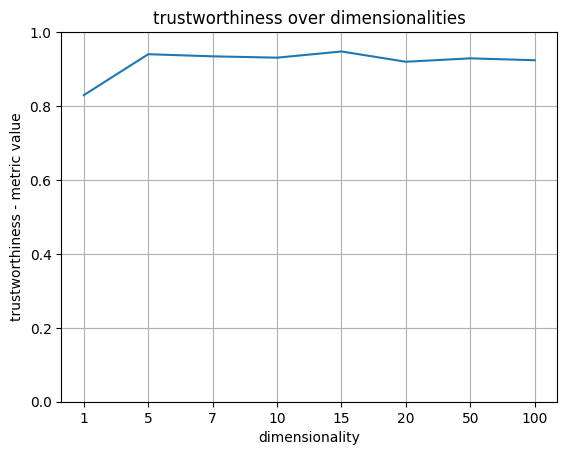

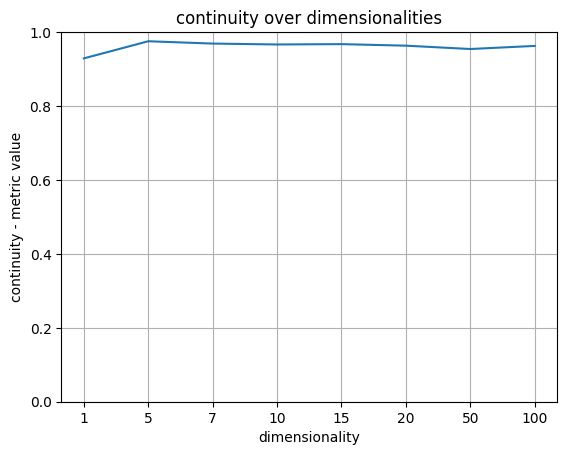

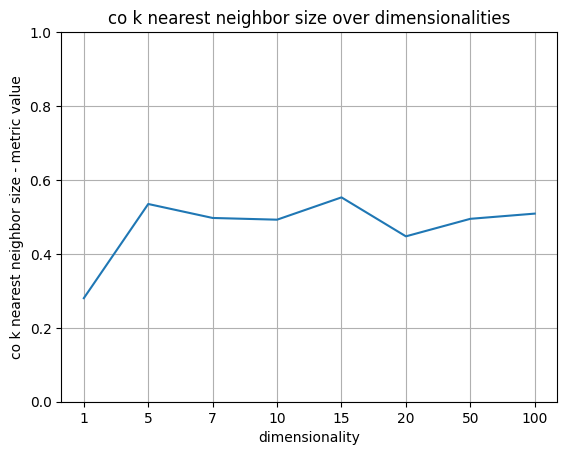

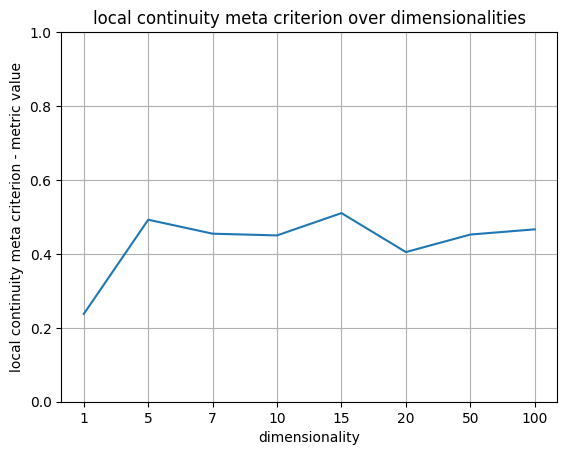

In [35]:
criteria_set = ['trustworthiness', 'continuity', 'co k nearest neighbor size', 'local continuity meta criterion']
for criteria_unit in criteria_set:
    plot_criteria(criteria_unit)

In [36]:
print(lowdim_classification_eval)

[{'runs': [{'run id': 1, 'start': 1663861384.7471433, 'end': 1663861385.1162555, 'time taken': 0.3691122531890869, 'result': [{'accuracy': 0.31216931216931215, 'f1 score (weighted)': 0.31722656632079277, 'f1 score (micro)': 0.31216931216931215, 'f1 score (macro)': 0.3071120580178316}]}, {'run id': 2, 'start': 1663861385.116258, 'end': 1663861385.4773123, 'time taken': 0.3610544204711914, 'result': [{'accuracy': 0.31216931216931215, 'f1 score (weighted)': 0.31722656632079277, 'f1 score (micro)': 0.31216931216931215, 'f1 score (macro)': 0.3071120580178316}]}, {'run id': 3, 'start': 1663861385.477314, 'end': 1663861385.8370614, 'time taken': 0.35974740982055664, 'result': [{'accuracy': 0.31216931216931215, 'f1 score (weighted)': 0.31722656632079277, 'f1 score (micro)': 0.31216931216931215, 'f1 score (macro)': 0.3071120580178316}]}]}, {'runs': [{'run id': 1, 'start': 1663861485.1534908, 'end': 1663861485.6551821, 'time taken': 0.5016913414001465, 'result': [{'accuracy': 0.6878306878306878,

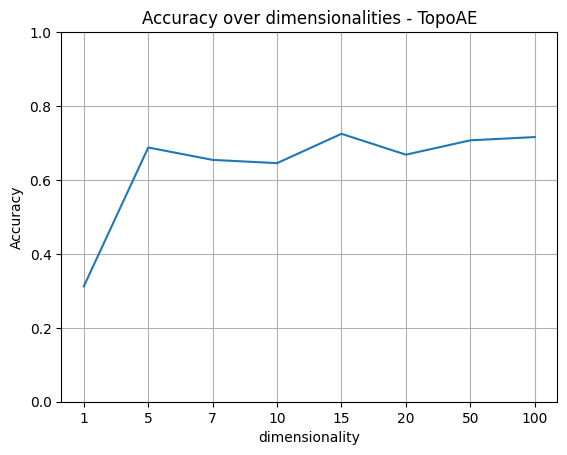

In [37]:
criteria = 'accuracy'
    
f1_values_runs = [evaluation['runs'] for evaluation in lowdim_classification_eval]
accuracy_over_dimensions = []
for evaluation in lowdim_classification_eval:
    runs = evaluation['runs']
    criteria_set = []
    for run in runs:
        criteria_set.append(run['result'][0][criteria])
        # print('run id', run['run id'])
        # print(run['result'][0][criteria])
    accuracy_over_dimensions.append(np.mean(criteria_set))
x = np.array(range(len(dimensions)))
my_xticks = [str(val) for val in dimensions]
plt.xticks(x, my_xticks)
plt.grid()
plt.plot(accuracy_over_dimensions)
plt.title('Accuracy over dimensionalities - TopoAE')
plt.ylabel('Accuracy')
plt.xlabel('dimensionality')
plt.ylim((0,1))
plt.show()
    
# print(f1_values_runs)